Centerline 0 has been saved to C:\Users\shubh\Documents\Analytics\Haul Roads WS\HaulRoads Data Files\Centerlines\centerline_0.shp
Centerline 1 has been saved to C:\Users\shubh\Documents\Analytics\Haul Roads WS\HaulRoads Data Files\Centerlines\centerline_1.shp
Centerline 2 has been saved to C:\Users\shubh\Documents\Analytics\Haul Roads WS\HaulRoads Data Files\Centerlines\centerline_2.shp
Centerline 3 has been saved to C:\Users\shubh\Documents\Analytics\Haul Roads WS\HaulRoads Data Files\Centerlines\centerline_3.shp
Centerline 4 has been saved to C:\Users\shubh\Documents\Analytics\Haul Roads WS\HaulRoads Data Files\Centerlines\centerline_4.shp
Normals for centerline 0 have been saved to C:\Users\shubh\Documents\Analytics\Haul Roads WS\HaulRoads Data Files\Normals\normal_0.shp
Lengths of normals for centerline 0: [0.3999999995773821, 1.999999999761943, 2.4000000002087214, 1.8000000000101983, 2.1999999999672553, 2.199999999772209, 2.400000000118637, 2.400000000201841, 2.2000000002160807, 1

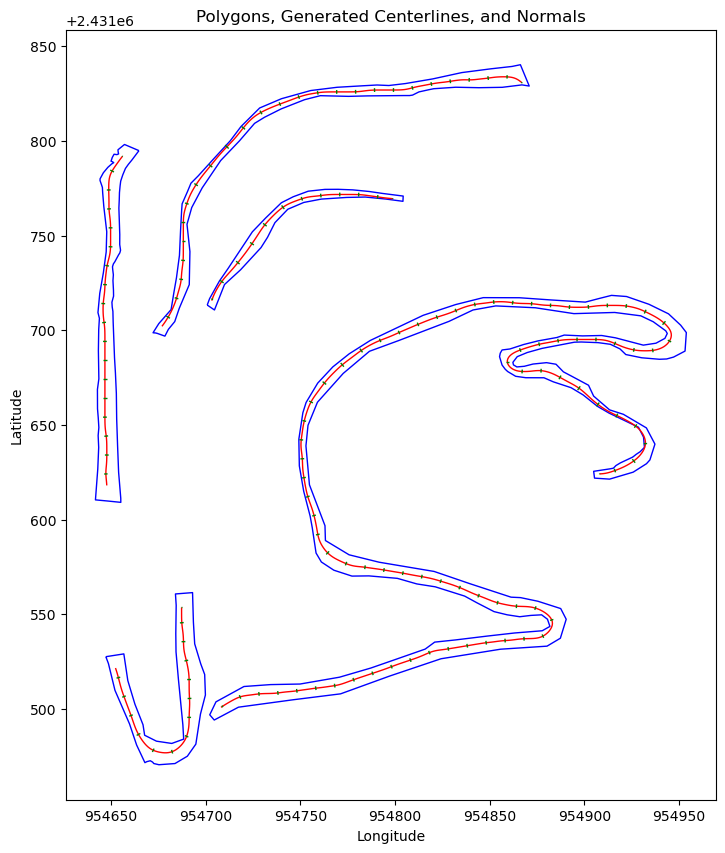

In [1]:
import geopandas as gpd
from shapely.geometry import LineString, Polygon, MultiLineString, Point
from shapely.ops import linemerge
from shapely.validation import make_valid
from skimage.morphology import skeletonize, thin
from scipy.ndimage import gaussian_filter
import sknw
import numpy as np
import rasterio
from rasterio.features import rasterize
import matplotlib.pyplot as plt
import os

def merge_lines(lines):
    # Merge lines and handle both LineString and MultiLineString outputs
    merged = linemerge(lines)
    if isinstance(merged, LineString):
        return [merged]
    elif isinstance(merged, MultiLineString):
        return list(merged.geoms)
    return []

def smooth_line(line, smoothing_factor=3):
    x, y = line.xy
    x = gaussian_filter(x, smoothing_factor)
    y = gaussian_filter(y, smoothing_factor)
    return LineString(np.column_stack([x, y]))

def get_centerline(polygon, resolution=1):
    # Create a binary image from the polygon
    bounds = polygon.bounds
    transform = rasterio.transform.from_bounds(*bounds, int((bounds[2]-bounds[0])/resolution), int((bounds[3]-bounds[1])/resolution))
    binary_image = rasterize([polygon], out_shape=(int((bounds[3]-bounds[1])/resolution), int((bounds[2]-bounds[0])/resolution)), transform=transform, fill=0, all_touched=True)

    # Smooth the binary image
    binary_image = gaussian_filter(binary_image.astype(float), sigma=1)
    binary_image = (binary_image > 0.5).astype(np.uint8)

    # Skeletonize the binary image
    skeleton = thin(binary_image)

    # Generate centerlines using sknw
    graph = sknw.build_sknw(skeleton)
    
    # Extract the main branches from the skeleton
    lines = []
    for (s, e) in graph.edges():
        ps = graph[s][e]['pts']
        # Transform pixel coords to spatial coords, accounting for flipping
        coords = [(p[1] * resolution + bounds[0], (binary_image.shape[0] - p[0]) * resolution + bounds[1]) for p in ps]
        line = LineString(coords)
        lines.append(line)
    
    return lines

def generate_normals(centerline, polygon, interval=10):
    normals = []
    for i in range(0, len(centerline.coords) - 1, interval):
        p1 = Point(centerline.coords[i])
        p2 = Point(centerline.coords[i+1])
        dx = p2.x - p1.x
        dy = p2.y - p1.y
        length = np.sqrt(dx**2 + dy**2)
        nx = -dy / length
        ny = dx / length
        
        normal_length = 0
        for dist in np.arange(0.1, length, 0.1):
            n1 = Point(p1.x + nx * dist, p1.y + ny * dist)
            n2 = Point(p1.x - nx * dist, p1.y - ny * dist)
            if polygon.contains(n1):
                normal_length = dist
            if polygon.contains(n2):
                normal_length = dist
        
        if normal_length > 0:
            normal_line = LineString([Point(p1.x + nx * normal_length, p1.y + ny * normal_length), Point(p1.x - nx * normal_length, p1.y - ny * normal_length)])
            normals.append(normal_line)
    
    return normals

# Step 1: Read the shapefile
input_shapefile = r"C:\Users\shubh\Documents\Analytics\Haul Roads WS\HaulRoads Data Files\HaulRoads_SHP.shp"
gdf = gpd.read_file(input_shapefile)

# Step 2: Initialize a list to hold final centerlines
final_centerlines = []

# Step 3: Process each polygon to generate and merge centerlines
for poly in gdf.geometry:
    if isinstance(poly, Polygon):
        # Generate initial centerlines
        initial_lines = get_centerline(poly)
        merged_initial_lines = merge_lines(initial_lines)
        
        # Validate and fix centerlines to avoid topology errors
        valid_centerlines = [make_valid(line) for line in merged_initial_lines]
        
        # Smooth the centerlines
        smoothed_centerlines = [smooth_line(line) for line in valid_centerlines]
        
        final_centerlines.extend(smoothed_centerlines)
    else:
        print(f"Non-polygon geometry found: {type(poly)}. Skipping...")

# Step 4: Save each centerline to a separate shapefile
output_directory = r"C:\Users\shubh\Documents\Analytics\Haul Roads WS\HaulRoads Data Files\Centerlines"
os.makedirs(output_directory, exist_ok=True)

for i, centerline in enumerate(final_centerlines):
    centerline_gdf = gpd.GeoDataFrame(geometry=[centerline], crs=gdf.crs)
    output_shapefile = os.path.join(output_directory, f"centerline_{i}.shp")
    centerline_gdf.to_file(output_shapefile)
    print(f"Centerline {i} has been saved to {output_shapefile}")

# Step 5: Generate and save normal lines for each centerline
normals_output_directory = r"C:\Users\shubh\Documents\Analytics\Haul Roads WS\HaulRoads Data Files\Normals"
os.makedirs(normals_output_directory, exist_ok=True)

for i, (centerline, poly) in enumerate(zip(final_centerlines, gdf.geometry)):
    normals = generate_normals(centerline, poly)
    normal_lengths = [line.length for line in normals]
    normal_gdf = gpd.GeoDataFrame(geometry=normals, crs=gdf.crs)
    
    # Save normals to a separate shapefile
    output_normal_shapefile = os.path.join(normals_output_directory, f"normal_{i}.shp")
    normal_gdf.to_file(output_normal_shapefile)
    print(f"Normals for centerline {i} have been saved to {output_normal_shapefile}")
    
    # Print lengths of normals
    print(f"Lengths of normals for centerline {i}: {normal_lengths}")

# Step 6: Plot the results using matplotlib
fig, ax = plt.subplots(figsize=(10, 10))
gdf.boundary.plot(ax=ax, linewidth=1, edgecolor='blue')
for centerline in final_centerlines:
    gpd.GeoSeries([centerline]).plot(ax=ax, linewidth=1, color='red')
for i, (centerline, poly) in enumerate(zip(final_centerlines, gdf.geometry)):
    normals = generate_normals(centerline, poly)
    for normal in normals:
        gpd.GeoSeries([normal]).plot(ax=ax, linewidth=1, color='green')
plt.title("Polygons, Generated Centerlines, and Normals")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()


Centerline 0 has been saved to C:\Users\shubh\Documents\Analytics\Haul Roads WS\HaulRoads Data Files\Centerlines\centerline_0.shp
Centerline 1 has been saved to C:\Users\shubh\Documents\Analytics\Haul Roads WS\HaulRoads Data Files\Centerlines\centerline_1.shp
Centerline 2 has been saved to C:\Users\shubh\Documents\Analytics\Haul Roads WS\HaulRoads Data Files\Centerlines\centerline_2.shp
Centerline 3 has been saved to C:\Users\shubh\Documents\Analytics\Haul Roads WS\HaulRoads Data Files\Centerlines\centerline_3.shp
Centerline 4 has been saved to C:\Users\shubh\Documents\Analytics\Haul Roads WS\HaulRoads Data Files\Centerlines\centerline_4.shp


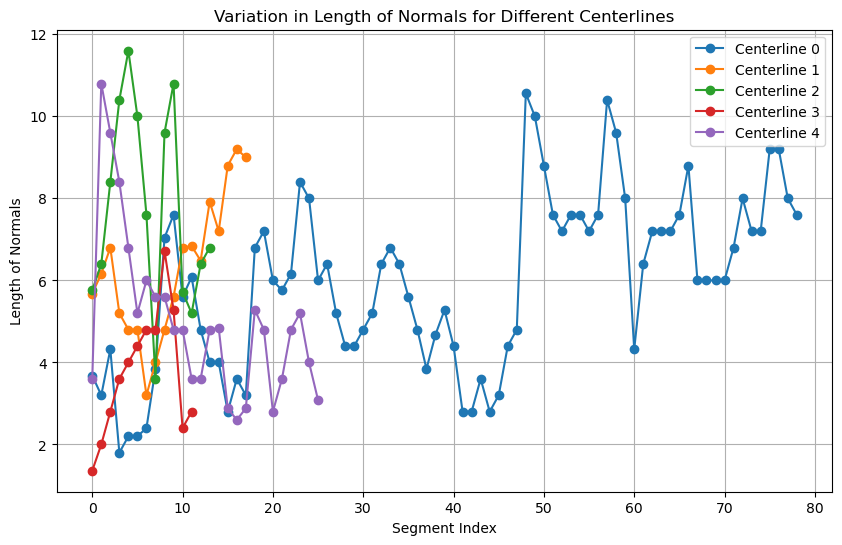

In [11]:
import geopandas as gpd
from shapely.geometry import LineString, Polygon, MultiLineString, Point
from shapely.ops import linemerge
from shapely.validation import make_valid
from skimage.morphology import thin
from scipy.ndimage import gaussian_filter
import sknw
import numpy as np
import rasterio
from rasterio.features import rasterize
import matplotlib.pyplot as plt
import os

def merge_lines(lines):
    # Merge lines and handle both LineString and MultiLineString outputs
    merged = linemerge(lines)
    if isinstance(merged, LineString):
        return [merged]
    elif isinstance(merged, MultiLineString):
        return list(merged.geoms)
    return []

def smooth_line(line, smoothing_factor=3):
    x, y = line.xy
    x = gaussian_filter(x, smoothing_factor)
    y = gaussian_filter(y, smoothing_factor)
    return LineString(np.column_stack([x, y]))

def get_centerline(polygon, resolution=1):
    # Create a binary image from the polygon
    bounds = polygon.bounds
    transform = rasterio.transform.from_bounds(*bounds, int((bounds[2]-bounds[0])/resolution), int((bounds[3]-bounds[1])/resolution))
    binary_image = rasterize([polygon], out_shape=(int((bounds[3]-bounds[1])/resolution), int((bounds[2]-bounds[0])/resolution)), transform=transform, fill=0, all_touched=True)

    # Smooth the binary image
    binary_image = gaussian_filter(binary_image.astype(float), sigma=1)
    binary_image = (binary_image > 0.5).astype(np.uint8)

    # Skeletonize the binary image
    skeleton = thin(binary_image)

    # Generate centerlines using sknw
    graph = sknw.build_sknw(skeleton)
    
    # Extract the main branches from the skeleton
    lines = []
    for (s, e) in graph.edges():
        ps = graph[s][e]['pts']
        # Transform pixel coords to spatial coords, accounting for flipping
        coords = [(p[1] * resolution + bounds[0], (binary_image.shape[0] - p[0]) * resolution + bounds[1]) for p in ps]
        line = LineString(coords)
        lines.append(line)
    
    return lines

def extend_normal(normal_line, polygon):
    extended_line = normal_line
    if polygon.contains(normal_line):
        # Extend the normal line in both directions until it intersects with the polygon edges
        direction_vector = normal_line.coords[1][0] - normal_line.coords[0][0], normal_line.coords[1][1] - normal_line.coords[0][1]
        step_size = 0.1  # Adjust this value based on your resolution or step size
        
        while polygon.contains(extended_line):
            extended_line = LineString([(extended_line.coords[0][0] - direction_vector[0] * step_size, extended_line.coords[0][1] - direction_vector[1] * step_size),
                                        (extended_line.coords[1][0] + direction_vector[0] * step_size, extended_line.coords[1][1] + direction_vector[1] * step_size)])
        
        return extended_line
    else:
        return normal_line

def generate_normals_extended(centerline, polygon, interval=10):
    normals = []
    normal_lengths = []
    for i in range(0, len(centerline.coords) - 1, interval):
        p1 = Point(centerline.coords[i])
        p2 = Point(centerline.coords[i+1])
        dx = p2.x - p1.x
        dy = p2.y - p1.y
        length = np.sqrt(dx**2 + dy**2)
        nx = -dy / length
        ny = dx / length
        
        normal_length = 0
        for dist in np.arange(0.1, length, 0.1):
            n1 = Point(p1.x + nx * dist, p1.y + ny * dist)
            n2 = Point(p1.x - nx * dist, p1.y - ny * dist)
            if polygon.contains(n1):
                normal_length = dist
            if polygon.contains(n2):
                normal_length = dist
        
        if normal_length > 0:
            normal_line = LineString([Point(p1.x + nx * normal_length, p1.y + ny * normal_length), Point(p1.x - nx * normal_length, p1.y - ny * normal_length)])
            extended_normal = extend_normal(normal_line, polygon)
            normals.append(extended_normal)
            normal_lengths.append(extended_normal.length)
    
    return normals, normal_lengths

# Step 1: Read the shapefile
input_shapefile = r"C:\Users\shubh\Documents\Analytics\Haul Roads WS\HaulRoads Data Files\HaulRoads_SHP.shp"
gdf = gpd.read_file(input_shapefile)

# Step 2: Initialize a list to hold final centerlines
final_centerlines = []

# Step 3: Process each polygon to generate and merge centerlines
for poly in gdf.geometry:
    if isinstance(poly, Polygon):
        # Generate initial centerlines
        initial_lines = get_centerline(poly)
        merged_initial_lines = merge_lines(initial_lines)
        
        # Validate and fix centerlines to avoid topology errors
        valid_centerlines = [make_valid(line) for line in merged_initial_lines]
        
        # Smooth the centerlines
        smoothed_centerlines = [smooth_line(line) for line in valid_centerlines]
        
        final_centerlines.extend(smoothed_centerlines)
    else:
        print(f"Non-polygon geometry found: {type(poly)}. Skipping...")

# Step 4: Save each centerline to a separate shapefile
output_directory = r"C:\Users\shubh\Documents\Analytics\Haul Roads WS\HaulRoads Data Files\Centerlines"
os.makedirs(output_directory, exist_ok=True)

for i, centerline in enumerate(final_centerlines):
    centerline_gdf = gpd.GeoDataFrame(geometry=[centerline], crs=gdf.crs)
    output_shapefile = os.path.join(output_directory, f"centerline_{i}.shp")
    centerline_gdf.to_file(output_shapefile)
    print(f"Centerline {i} has been saved to {output_shapefile}")

# Step 5: Generate and plot variation in normal lengths for each centerline
fig, ax = plt.subplots(figsize=(10, 6))

for i, (centerline, poly) in enumerate(zip(final_centerlines, gdf.geometry)):
    normals, normal_lengths = generate_normals_extended(centerline, poly)
    ax.plot(normal_lengths, label=f'Centerline {i}', marker='o')

ax.set_xlabel('Segment Index')
ax.set_ylabel('Length of Normals')
ax.set_title('Variation in Length of Normals for Different Centerlines')
ax.legend()
plt.grid(True)
plt.show()
